In [58]:
#################### DOWNLOAD AND UNZIP FILE SAVED IN DRIVE ####################

!pip install -U -q PyDrive

# HERE YOUR FILE ID ( GET IT WITH THE SHARING URL: )
zip_id = '1OiDe5XYrAMBzOZTrR6q3vg4R1xjfCwFW'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('ECommerce'):
    os.makedirs('ECommerce')

# DOWNLOAD ZIP
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('ECommerce.zip')

# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('ECommerce.zip', 'r')
zip_ref.extractall('ECommerce/')
zip_ref.close()

Uncompressing zip file


In [59]:
!ls

adc.json			 catboost_info	ECommerce.zip
catboost_feature_importance.png  ECommerce	sample_data


In [60]:
!ls '/content/ECommerce'

E-Commerce_Participants_Data  __MACOSX


In [61]:
!ls '/content/ECommerce/E-Commerce_Participants_Data'

Sample_Submission.xlsx	Test.csv  Train.csv


### Load Packages

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns  
from sklearn import metrics, preprocessing, model_selection
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score
import datetime 
import time
from scipy.stats import hmean
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,cross_val_score, GridSearchCV, RepeatedStratifiedKFold
import lightgbm as lgb
import matplotlib.pyplot as plt

%matplotlib inline

SEED = 1

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [63]:
!pip install catboost

### Read the dataset

In [0]:
file = r'/content/ECommerce/E-Commerce_Participants_Data/'
train_df = pd.read_csv(file+'Train.csv')
test_df = pd.read_csv(file+'Test.csv')
sub_df = pd.read_excel(file+'Sample_Submission.xlsx')

In [65]:
train_df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2/3/2017,291.0
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,7/1/2015,897.0
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,1/12/2019,792.0
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,12/12/2014,837.0
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,12/12/2013,470.0


In [66]:
test_df.head()


,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date
0,P-11284,B-2984,computers,network components,routers,4.3,1/12/2018
1,P-6580,B-1732,jewellery,bangles bracelets armlets,bracelets,3.0,20/12/2012
2,P-5843,B-3078,clothing,women s clothing,western wear,1.5,1/12/2014
3,P-5334,B-1421,jewellery,necklaces chains,necklaces,3.9,1/12/2019
4,P-5586,B-3078,clothing,women s clothing,western wear,1.4,1/12/2017


In [67]:
sub_df.head()

,Selling_Price
0,2921.95
1,508.47
2,802.71
3,402.79
4,751.10


In [68]:
print(train_df.shape, test_df.shape)

(2452, 8) (1051, 7)


In [69]:
print(f'Number of samples in train: {train_df.shape[0]}')
print(f'Number of columns in train: {train_df.shape[1]}')
for col in train_df.columns:
    if train_df[col].isnull().any():
        print(col, train_df[col].isnull().sum())

Number of samples in train: 2452
Number of columns in train: 8


In [70]:
print(f'Number of samples in test: {test_df.shape[0]}')
print(f'Number of columns in test: {test_df.shape[1]}')
for col in test_df.columns:
    if test_df[col].isnull().any():
        print(col, test_df[col].isnull().sum())

Number of samples in test: 1051
Number of columns in test: 7


In [71]:
train_df.dtypes

Product           object
Product_Brand     object
Item_Category     object
Subcategory_1     object
Subcategory_2     object
Item_Rating      float64
Date              object
Selling_Price    float64
dtype: object

In [72]:
train_df.isnull().sum()

Product          0
Product_Brand    0
Item_Category    0
Subcategory_1    0
Subcategory_2    0
Item_Rating      0
Date             0
Selling_Price    0
dtype: int64

In [73]:
test_df.isnull().sum()

Product          0
Product_Brand    0
Item_Category    0
Subcategory_1    0
Subcategory_2    0
Item_Rating      0
Date             0
dtype: int64

In [74]:
train_df.columns

Index(['Product', 'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2', 'Item_Rating', 'Date', 'Selling_Price'],
      dtype='object')

In [75]:
#find overlap between train and test sets
cols =  [
            'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2'
          ]
for col in cols:
  print('Total unique'+col  +' values in Train are {}'.format(train_df[col].nunique()))
  print('Total unique'+col  +' values in Test are {}'.format(test_df[col].nunique()))
  print('Common'+col +' values are {}'.format(len(list(set(train_df[col]) & set(test_df[col])))))
  print('**************************')

Total uniqueProduct_Brand values in Train are 1010
Total uniqueProduct_Brand values in Test are 494
CommonProduct_Brand values are 191
**************************
Total uniqueItem_Category values in Train are 75
Total uniqueItem_Category values in Test are 47
CommonItem_Category values are 27
**************************
Total uniqueSubcategory_1 values in Train are 130
Total uniqueSubcategory_1 values in Test are 93
CommonSubcategory_1 values are 81
**************************
Total uniqueSubcategory_2 values in Train are 336
Total uniqueSubcategory_2 values in Test are 194
CommonSubcategory_2 values are 135
**************************


In [0]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['Missing %'] = ((df.isnull().sum().values)/ (df.shape[0])) *100
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [77]:
resumetable(train_df)

Dataset Shape: (2452, 8)


,Name,dtypes,Missing,Uniques,Missing %,First Value,Second Value,Third Value,Entropy
0,Product,object,0,2452,0.0,P-2610,P-2453,P-6802,11.26
1,Product_Brand,object,0,1010,0.0,B-659,B-3078,B-1810,7.42
2,Item_Category,object,0,75,0.0,bags wallets belts,clothing,home decor festive needs,3.70
3,Subcategory_1,object,0,130,0.0,bags,women s clothing,showpieces,5.06
4,Subcategory_2,object,0,336,0.0,hand bags,western wear,ethnic,6.24
5,Item_Rating,float64,0,41,0.0,4.3,3.1,3.5,5.33
6,Date,object,0,483,0.0,2/3/2017,7/1/2015,1/12/2019,7.54
7,Selling_Price,float64,0,1095,0.0,291,897,792,9.54


In [78]:
resumetable(test_df)

Dataset Shape: (1051, 7)


,Name,dtypes,Missing,Uniques,Missing %,First Value,Second Value,Third Value,Entropy
0,Product,object,0,1051,0.0,P-11284,P-6580,P-5843,10.04
1,Product_Brand,object,0,494,0.0,B-2984,B-1732,B-3078,6.74
2,Item_Category,object,0,47,0.0,computers,jewellery,clothing,3.64
3,Subcategory_1,object,0,93,0.0,network components,bangles bracelets armlets,women s clothing,4.92
4,Subcategory_2,object,0,194,0.0,routers,bracelets,western wear,5.94
5,Item_Rating,float64,0,41,0.0,4.3,3,1.5,5.31
6,Date,object,0,318,0.0,1/12/2018,20/12/2012,1/12/2014,7.35


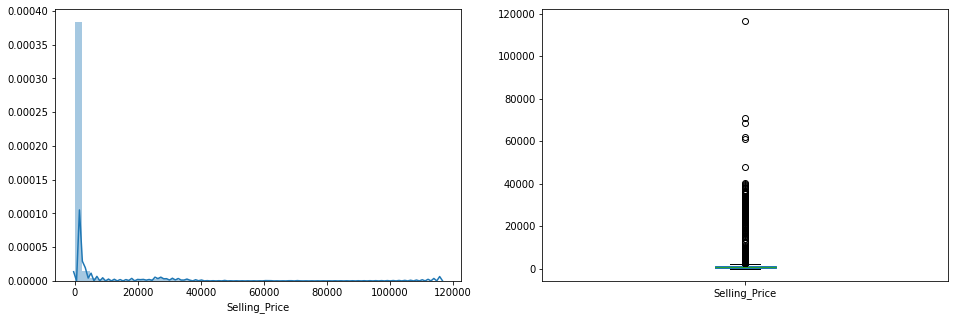

In [79]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df['Selling_Price'])


plt.subplot(122)
train_df['Selling_Price'].plot.box(figsize=(16,5))

plt.show()

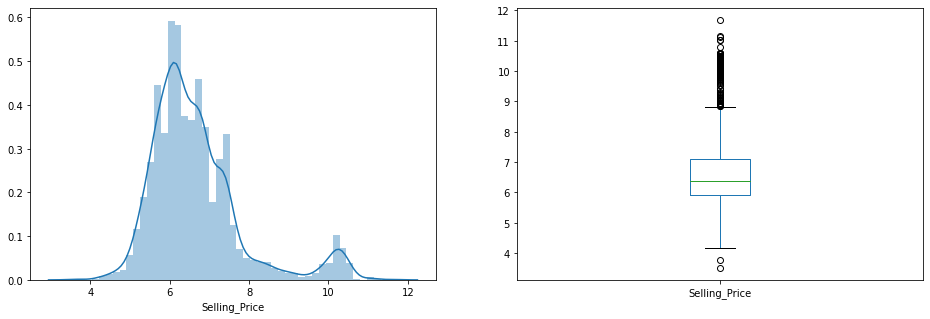

In [80]:
plt.figure(1)
plt.subplot(121)
sns.distplot(np.log1p(train_df['Selling_Price']))


plt.subplot(122)
np.log1p(train_df['Selling_Price']).plot.box(figsize=(16,5))

plt.show()

In [0]:
#Testing for resampling
resampled_train_df = train_df.copy()
resampled_test_df = test_df.copy()

### Feature Engineering

In [0]:
# * join the datasets
train_df['is_train']  = 1
test_df['Selling_Price'] = 0
test_df['is_train'] = 0

In [0]:
full_df = train_df.append(test_df)

In [0]:
full_df['Date'] = pd.to_datetime(full_df['Date'])

In [85]:
full_df['Date'].min(), full_df['Date'].max()

(Timestamp('2012-01-12 00:00:00'), Timestamp('2020-12-06 00:00:00'))

In [0]:
def create_date_featues(df):
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    df['Day'] = pd.to_datetime(df['Date']).dt.day
    df['Dayofweek'] = pd.to_datetime(df['Date']).dt.dayofweek
    df['DayOfyear'] = pd.to_datetime(df['Date']).dt.dayofyear
    df['Week'] = pd.to_datetime(df['Date']).dt.week 
    df['Quarter'] = pd.to_datetime(df['Date']).dt.quarter  
    df['Is_month_start'] = pd.to_datetime(df['Date']).dt.is_month_start 
    df['Is_month_end'] = pd.to_datetime(df['Date']).dt.is_month_end 
    df['Is_quarter_start'] = pd.to_datetime(df['Date']).dt.is_quarter_start
    df['Is_quarter_end'] = pd.to_datetime(df['Date']).dt.is_quarter_end 
    df['Is_year_start'] = pd.to_datetime(df['Date']).dt.is_year_start 
    df['Is_year_end'] = pd.to_datetime(df['Date']).dt.is_year_end
    df['Semester'] = np.where(df['Quarter'].isin([1,2]),1,2)   
    df['Is_weekday'] = np.where(df['Dayofweek'].isin([0,1,2,3,4]),1,0) 
    df['Days_in_month'] = pd.to_datetime(df['Date']).dt.days_in_month 
    
    return df

In [0]:
full_df = create_date_featues(full_df)

In [88]:
full_df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price,is_train,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekday,Days_in_month
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2017-02-03,291.0,1,2017,2,3,4,34,5,1,False,False,False,False,False,False,1,1,28
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,2015-07-01,897.0,1,2015,7,1,2,182,27,3,True,False,True,False,False,False,2,1,31
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,2019-01-12,792.0,1,2019,1,12,5,12,2,1,False,False,False,False,False,False,1,0,31
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,2014-12-12,837.0,1,2014,12,12,4,346,50,4,False,False,False,False,False,False,2,1,31
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,2013-12-12,470.0,1,2013,12,12,3,346,50,4,False,False,False,False,False,False,2,1,31


In [0]:
Product_Brand_Day_grpd = full_df.groupby(['Product_Brand', 'Day']).agg({'Item_Rating': ['mean', 'max', 'min'],
                                                     'Subcategory_1': ['nunique'], 
                                                     'Subcategory_2': ['nunique'],
                                                     'Item_Category': ['nunique']  
                                                     })
Product_Brand_Day_grpd.columns = ['grpd_by_Product_Brand_Day_' + '_'.join(c).strip('_') for c in Product_Brand_Day_grpd.columns]
full_df = pd.merge(full_df, Product_Brand_Day_grpd, on = ['Product_Brand', 'Day'], how='left')


In [0]:
Subcategory_1_Day_grpd = full_df.groupby(['Subcategory_1', 'Day']).agg({'Item_Rating': ['mean', 'max', 'min'],
                                                     'Product_Brand': ['nunique'], 
                                                     'Subcategory_2': ['nunique'],
                                                     'Item_Category': ['nunique'] 
                                                     })
Subcategory_1_Day_grpd.columns = ['grpd_by_Subcategory_1_Day_' + '_'.join(c).strip('_') for c in Subcategory_1_Day_grpd.columns]
full_df = pd.merge(full_df, Subcategory_1_Day_grpd, on = ['Subcategory_1', 'Day'], how='left')

In [91]:
full_df.shape

(3503, 37)

In [0]:
###  count features ###
gdf = full_df.groupby(["Subcategory_1"])["Product"].count().reset_index()
gdf.columns = ["Subcategory_1", "Subcategory_1_count"]
full_df = full_df.merge(gdf, on=["Subcategory_1"], how="left")

gdf = full_df.groupby(["Subcategory_1", "Week"])["Product"].count().reset_index()
gdf.columns = ["Subcategory_1", "Week", "Subcategory_1_Week_count"]
full_df = full_df.merge(gdf, on=["Subcategory_1", "Week"], how="left")

gdf = full_df.groupby(["Product_Brand", "Week"])["Product"].count().reset_index()
gdf.columns = ["Product_Brand", "Week", "Product_Brand_Week_count"]
full_df = full_df.merge(gdf, on=["Product_Brand", "Week"], how="left")

gdf = full_df.groupby(["Product_Brand", "Subcategory_1", "Week"])["Product"].count().reset_index()
gdf.columns = ["Product_Brand", "Subcategory_1", "Week", "Product_Brand_Subcategory_1_week_count"]
full_df = full_df.merge(gdf, on=["Product_Brand", "Subcategory_1", "Week"], how="left")

gdf = full_df.groupby(["Subcategory_1", "Subcategory_2", "Week"])["Product"].count().reset_index()
gdf.columns = ["Subcategory_1", "Subcategory_2", "Week", "Subcategory_1_Subcategory_2_week_count"]
full_df = full_df.merge(gdf, on=["Subcategory_1", "Subcategory_2", "Week"], how="left")

gdf = full_df.groupby(["Product_Brand", "Subcategory_2", "Week"])["Product"].count().reset_index()
gdf.columns = ["Product_Brand", "Subcategory_2", "Week", "Product_Brand_Subcategory_2_week_count"]
full_df = full_df.merge(gdf, on=["Product_Brand", "Subcategory_2", "Week"], how="left")

In [0]:
###  count features ###

gdf = full_df.groupby(["Subcategory_1", "Quarter"])["Product"].count().reset_index()
gdf.columns = ["Subcategory_1", "Quarter", "Subcategory_1_Quarter_count"]
full_df = full_df.merge(gdf, on=["Subcategory_1", "Quarter"], how="left")

gdf = full_df.groupby(["Product_Brand", "Quarter"])["Product"].count().reset_index()
gdf.columns = ["Product_Brand", "Quarter", "Product_Brand_Quarter_count"]
full_df = full_df.merge(gdf, on=["Product_Brand", "Quarter"], how="left")

gdf = full_df.groupby(["Product_Brand", "Subcategory_1", "Quarter"])["Product"].count().reset_index()
gdf.columns = ["Product_Brand", "Subcategory_1", "Quarter", "Product_Brand_Subcategory_1_Quarter_count"]
full_df = full_df.merge(gdf, on=["Product_Brand", "Subcategory_1", "Quarter"], how="left")

gdf = full_df.groupby(["Subcategory_1", "Subcategory_2", "Quarter"])["Product"].count().reset_index()
gdf.columns = ["Subcategory_1", "Subcategory_2", "Quarter", "Subcategory_1_Subcategory_2_Quarter_count"]
full_df = full_df.merge(gdf, on=["Subcategory_1", "Subcategory_2", "Quarter"], how="left")

gdf = full_df.groupby(["Product_Brand", "Subcategory_2", "Quarter"])["Product"].count().reset_index()
gdf.columns = ["Product_Brand", "Subcategory_2", "Quarter", "Product_Brand_Subcategory_2_Quarter_count"]
full_df = full_df.merge(gdf, on=["Product_Brand", "Subcategory_2", "Quarter"], how="left")

In [94]:
# append train and test data
testcount = len(test_df)
count = len(full_df)-testcount
print(count)

2452


In [0]:
train = full_df[:count]
test = full_df[count:]
train_df = train.copy()
test_df = test.copy()

In [96]:
train_df.columns

Index(['Product', 'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2', 'Item_Rating', 'Date', 'Selling_Price', 'is_train',
       'Year', 'Month', 'Day', 'Dayofweek', 'DayOfyear', 'Week', 'Quarter',
       'Is_month_start', 'Is_month_end', 'Is_quarter_start', 'Is_quarter_end',
       'Is_year_start', 'Is_year_end', 'Semester', 'Is_weekday',
       'Days_in_month', 'grpd_by_Product_Brand_Day_Item_Rating_mean',
       'grpd_by_Product_Brand_Day_Item_Rating_max',
       'grpd_by_Product_Brand_Day_Item_Rating_min',
       'grpd_by_Product_Brand_Day_Subcategory_1_nunique',
       'grpd_by_Product_Brand_Day_Subcategory_2_nunique',
       'grpd_by_Product_Brand_Day_Item_Category_nunique',
       'grpd_by_Subcategory_1_Day_Item_Rating_mean',
       'grpd_by_Subcategory_1_Day_Item_Rating_max',
       'grpd_by_Subcategory_1_Day_Item_Rating_min',
       'grpd_by_Subcategory_1_Day_Product_Brand_nunique',
       'grpd_by_Subcategory_1_Day_Subcategory_2_nunique',
       'grpd_b

In [97]:
train_df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price,is_train,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekday,Days_in_month,grpd_by_Product_Brand_Day_Item_Rating_mean,grpd_by_Product_Brand_Day_Item_Rating_max,grpd_by_Product_Brand_Day_Item_Rating_min,grpd_by_Product_Brand_Day_Subcategory_1_nunique,grpd_by_Product_Brand_Day_Subcategory_2_nunique,grpd_by_Product_Brand_Day_Item_Category_nunique,grpd_by_Subcategory_1_Day_Item_Rating_mean,grpd_by_Subcategory_1_Day_Item_Rating_max,grpd_by_Subcategory_1_Day_Item_Rating_min,grpd_by_Subcategory_1_Day_Product_Brand_nunique,grpd_by_Subcategory_1_Day_Subcategory_2_nunique,grpd_by_Subcategory_1_Day_Item_Category_nunique,Subcategory_1_count,Subcategory_1_Week_count,Product_Brand_Week_count,Product_Brand_Subcategory_1_week_count,Subcategory_1_Subcategory_2_week_count,Product_Brand_Subcategory_2_week_count,Subcategory_1_Quarter_count,Product_Brand_Quarter_count,Product_Brand_Subcategory_1_Quarter_count,Subcategory_1_Subcategory_2_Quarter_count,Product_Brand_Subcategory_2_Quarter_count
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2017-02-03,291.0,1,2017,2,3,4,34,5,1,False,False,False,False,False,False,1,1,28,4.300000,4.3,4.3,1,1,1,4.262500,4.9,3.5,8,3,1,40,3,1,1,3,1,23,1,1,12,1
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,2015-07-01,897.0,1,2015,7,1,2,182,27,3,True,False,True,False,False,False,2,1,31,3.186333,5.0,1.0,22,62,12,3.074906,5.0,1.0,33,8,1,695,138,117,43,37,34,208,169,63,52,49
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,2019-01-12,792.0,1,2019,1,12,5,12,2,1,False,False,False,False,False,False,1,0,31,2.650000,3.5,1.8,1,1,1,2.957576,5.0,1.2,24,12,1,45,31,2,2,18,2,37,2,2,19,2
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,2014-12-12,837.0,1,2014,12,12,4,346,50,4,False,False,False,False,False,False,2,1,31,3.131905,5.0,1.0,17,63,10,4.000000,4.0,4.0,1,1,1,2,1,138,1,1,1,1,353,1,1,1
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,2013-12-12,470.0,1,2013,12,12,3,346,50,4,False,False,False,False,False,False,2,1,31,3.131905,5.0,1.0,17,63,10,3.036170,5.0,1.0,7,6,1,243,83,138,74,72,72,130,353,110,73,73


In [0]:
def mean_likelihood(df, cat_var, target, alpha = 0.5):
    P_c = df.groupby(cat_var)[target].transform('mean')
    P_global = df[target].mean()
    n_c = df.groupby(cat_var)[target].transform('count')
    enc = (P_c*n_c + P_global*alpha)/(n_c + alpha)
    temp = df[[cat_var]]
    temp['enc'] = enc
    return temp.groupby(cat_var).mean()

cat_vars = [ 'Product_Brand', 'Item_Category', 'Subcategory_1',
            'Subcategory_2'
            
           ]
# getting mean encoding features
cvlist = list(KFold(n_splits = 10, random_state = 1).split(train_df))
for var in cat_vars:
    mean_enc_var = np.zeros(len(train_df))
    for tr_idx, val_idx in cvlist:
        X_tr, X_val = train_df.loc[tr_idx], train_df.loc[val_idx]
        X_tr_mean = mean_likelihood(X_tr, var, 'Selling_Price')
        mean_enc_var[val_idx] = X_val[var].map(X_tr_mean['enc'])
        train_df[f'mean_enc_{var}'] = mean_enc_var
    train_df[f'mean_enc_{var}'] = train_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())
    test_df[f'mean_enc_{var}'] = test_df[var].map(mean_likelihood(train_df, 
                                                                    var, 'Selling_Price')['enc'])
    test_df[f'mean_enc_{var}'] = test_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())

In [99]:
train_df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price,is_train,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekday,Days_in_month,grpd_by_Product_Brand_Day_Item_Rating_mean,grpd_by_Product_Brand_Day_Item_Rating_max,grpd_by_Product_Brand_Day_Item_Rating_min,grpd_by_Product_Brand_Day_Subcategory_1_nunique,grpd_by_Product_Brand_Day_Subcategory_2_nunique,grpd_by_Product_Brand_Day_Item_Category_nunique,grpd_by_Subcategory_1_Day_Item_Rating_mean,grpd_by_Subcategory_1_Day_Item_Rating_max,grpd_by_Subcategory_1_Day_Item_Rating_min,grpd_by_Subcategory_1_Day_Product_Brand_nunique,grpd_by_Subcategory_1_Day_Subcategory_2_nunique,grpd_by_Subcategory_1_Day_Item_Category_nunique,Subcategory_1_count,Subcategory_1_Week_count,Product_Brand_Week_count,Product_Brand_Subcategory_1_week_count,Subcategory_1_Subcategory_2_week_count,Product_Brand_Subcategory_2_week_count,Subcategory_1_Quarter_count,Product_Brand_Quarter_count,Product_Brand_Subcategory_1_Quarter_count,Subcategory_1_Subcategory_2_Quarter_count,Product_Brand_Subcategory_2_Quarter_count,mean_enc_Product_Brand,mean_enc_Item_Category,mean_enc_Subcategory_1,mean_enc_Subcategory_2
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2017-02-03,291.0,1,2017,2,3,4,34,5,1,False,False,False,False,False,False,1,1,28,4.300000,4.3,4.3,1,1,1,4.262500,4.9,3.5,8,3,1,40,3,1,1,3,1,23,1,1,12,1,2962.592733,1879.518178,1444.219476,2115.684970
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,2015-07-01,897.0,1,2015,7,1,2,182,27,3,True,False,True,False,False,False,2,1,31,3.186333,5.0,1.0,22,62,12,3.074906,5.0,1.0,33,8,1,695,138,117,43,37,34,208,169,63,52,49,788.278966,704.479964,632.494423,656.099689
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,2019-01-12,792.0,1,2019,1,12,5,12,2,1,False,False,False,False,False,False,1,0,31,2.650000,3.5,1.8,1,1,1,2.957576,5.0,1.2,24,12,1,45,31,2,2,18,2,37,2,2,19,2,1037.584769,1462.295481,1766.521259,1468.350172
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,2014-12-12,837.0,1,2014,12,12,4,346,50,4,False,False,False,False,False,False,2,1,31,3.131905,5.0,1.0,17,63,10,4.000000,4.0,4.0,1,1,1,2,1,138,1,1,1,1,353,1,1,1,788.278966,642.347659,1474.251435,2579.304850
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,2013-12-12,470.0,1,2013,12,12,3,346,50,4,False,False,False,False,False,False,2,1,31,3.131905,5.0,1.0,17,63,10,3.036170,5.0,1.0,7,6,1,243,83,138,74,72,72,130,353,110,73,73,788.278966,704.479964,858.522459,545.772561


In [100]:
test_df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price,is_train,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekday,Days_in_month,grpd_by_Product_Brand_Day_Item_Rating_mean,grpd_by_Product_Brand_Day_Item_Rating_max,grpd_by_Product_Brand_Day_Item_Rating_min,grpd_by_Product_Brand_Day_Subcategory_1_nunique,grpd_by_Product_Brand_Day_Subcategory_2_nunique,grpd_by_Product_Brand_Day_Item_Category_nunique,grpd_by_Subcategory_1_Day_Item_Rating_mean,grpd_by_Subcategory_1_Day_Item_Rating_max,grpd_by_Subcategory_1_Day_Item_Rating_min,grpd_by_Subcategory_1_Day_Product_Brand_nunique,grpd_by_Subcategory_1_Day_Subcategory_2_nunique,grpd_by_Subcategory_1_Day_Item_Category_nunique,Subcategory_1_count,Subcategory_1_Week_count,Product_Brand_Week_count,Product_Brand_Subcategory_1_week_count,Subcategory_1_Subcategory_2_week_count,Product_Brand_Subcategory_2_week_count,Subcategory_1_Quarter_count,Product_Brand_Quarter_count,Product_Brand_Subcategory_1_Quarter_count,Subcategory_1_Subcategory_2_Quarter_count,Product_Brand_Subcategory_2_Quarter_count,mean_enc_Product_Brand,mean_enc_Item_Category,mean_enc_Subcategory_1,mean_enc_Subcategory_2
2452,P-11284,B-2984,computers,network components,routers,4.3,2018-01-12,0.0,0,2018,1,12,4,12,2,1,False,False,False,False,False,False,1,1,31,3.350000,4.3,1.4,1,1,1,3.650943,5.0,1.0,25,1,1,55,46,3,3,46,3,54,4,4,54,4,1962.075122,2126.863041,3542.404419,3619.908140
2453,P-6580,B-1732,jewellery,bangles bracelets armlets,bracelets,3.0,2012-12-20,0.0,0,2012,12,20,3,355,51,4,False,False,False,False,False,False,2,1,31,2.800000,3.0,2.6,1,1,1,2.904878,5.0,1.1,32,2,1,114,41,2,2,32,2,102,2,2,35,2,2962.592733,8232.000438,962.905649,1661.425011
2454,P-5843,B-3078,clothing,women s clothing,western wear,1.5,2014-01-12,0.0,0,2014,1,12,6,12,2,1,False,False,False,False,False,False,1,0,31,3.131905,5.0,1.0,17,63,10,3.165546,5.0,1.0,3,7,1,695,84,252,83,68,68,172,357,123,114,100,782.020607,702.765419,632.191370,643.316590
2455,P-5334,B-1421,jewellery,necklaces chains,necklaces,3.9,2019-01-12,0.0,0,2019,1,12,5,12,2,1,False,False,False,False,False,False,1,0,31,2.250000,3.9,1.2,1,1,1,3.032227,5.0,1.0,102,1,1,221,187,5,5,187,5,211,6,6,211,6,640.486179,8232.000438,520.213008,517.887620
2456,P-5586,B-3078,clothing,women s clothing,western wear,1.4,2017-01-12,0.0,0,2017,1,12,3,12,2,1,False,False,False,False,False,False,1,1,31,3.131905,5.0,1.0,17,63,10,3.165546,5.0,1.0,3,7,1,695,84,252,83,68,68,172,357,123,114,100,782.020607,702.765419,632.191370,643.316590


### Baseline model

In [0]:
train_X = train_df.drop(['is_train','Product','Selling_Price', 'Date', 
                         'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2'],axis=1)
test_X = test_df.drop(['is_train','Product','Selling_Price', 'Date',
                       'Product_Brand', 'Item_Category', 'Subcategory_1',                     
       'Subcategory_2'],axis=1)
y = np.log1p(train_df['Selling_Price'])
train_y = y


X = train_X

median_price = np.median(np.expm1(train_df['Selling_Price'].values))


In [102]:
X.columns

Index(['Item_Rating', 'Year', 'Month', 'Day', 'Dayofweek', 'DayOfyear', 'Week',
       'Quarter', 'Is_month_start', 'Is_month_end', 'Is_quarter_start',
       'Is_quarter_end', 'Is_year_start', 'Is_year_end', 'Semester',
       'Is_weekday', 'Days_in_month',
       'grpd_by_Product_Brand_Day_Item_Rating_mean',
       'grpd_by_Product_Brand_Day_Item_Rating_max',
       'grpd_by_Product_Brand_Day_Item_Rating_min',
       'grpd_by_Product_Brand_Day_Subcategory_1_nunique',
       'grpd_by_Product_Brand_Day_Subcategory_2_nunique',
       'grpd_by_Product_Brand_Day_Item_Category_nunique',
       'grpd_by_Subcategory_1_Day_Item_Rating_mean',
       'grpd_by_Subcategory_1_Day_Item_Rating_max',
       'grpd_by_Subcategory_1_Day_Item_Rating_min',
       'grpd_by_Subcategory_1_Day_Product_Brand_nunique',
       'grpd_by_Subcategory_1_Day_Subcategory_2_nunique',
       'grpd_by_Subcategory_1_Day_Item_Category_nunique',
       'Subcategory_1_count', 'Subcategory_1_Week_count',
       'Product_Brand

In [103]:
X.shape

(2452, 44)

In [104]:
X.head()

,Item_Rating,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekday,Days_in_month,grpd_by_Product_Brand_Day_Item_Rating_mean,grpd_by_Product_Brand_Day_Item_Rating_max,grpd_by_Product_Brand_Day_Item_Rating_min,grpd_by_Product_Brand_Day_Subcategory_1_nunique,grpd_by_Product_Brand_Day_Subcategory_2_nunique,grpd_by_Product_Brand_Day_Item_Category_nunique,grpd_by_Subcategory_1_Day_Item_Rating_mean,grpd_by_Subcategory_1_Day_Item_Rating_max,grpd_by_Subcategory_1_Day_Item_Rating_min,grpd_by_Subcategory_1_Day_Product_Brand_nunique,grpd_by_Subcategory_1_Day_Subcategory_2_nunique,grpd_by_Subcategory_1_Day_Item_Category_nunique,Subcategory_1_count,Subcategory_1_Week_count,Product_Brand_Week_count,Product_Brand_Subcategory_1_week_count,Subcategory_1_Subcategory_2_week_count,Product_Brand_Subcategory_2_week_count,Subcategory_1_Quarter_count,Product_Brand_Quarter_count,Product_Brand_Subcategory_1_Quarter_count,Subcategory_1_Subcategory_2_Quarter_count,Product_Brand_Subcategory_2_Quarter_count,mean_enc_Product_Brand,mean_enc_Item_Category,mean_enc_Subcategory_1,mean_enc_Subcategory_2
0,4.3,2017,2,3,4,34,5,1,False,False,False,False,False,False,1,1,28,4.300000,4.3,4.3,1,1,1,4.262500,4.9,3.5,8,3,1,40,3,1,1,3,1,23,1,1,12,1,2962.592733,1879.518178,1444.219476,2115.684970
1,3.1,2015,7,1,2,182,27,3,True,False,True,False,False,False,2,1,31,3.186333,5.0,1.0,22,62,12,3.074906,5.0,1.0,33,8,1,695,138,117,43,37,34,208,169,63,52,49,788.278966,704.479964,632.494423,656.099689
2,3.5,2019,1,12,5,12,2,1,False,False,False,False,False,False,1,0,31,2.650000,3.5,1.8,1,1,1,2.957576,5.0,1.2,24,12,1,45,31,2,2,18,2,37,2,2,19,2,1037.584769,1462.295481,1766.521259,1468.350172
3,4.0,2014,12,12,4,346,50,4,False,False,False,False,False,False,2,1,31,3.131905,5.0,1.0,17,63,10,4.000000,4.0,4.0,1,1,1,2,1,138,1,1,1,1,353,1,1,1,788.278966,642.347659,1474.251435,2579.304850
4,4.3,2013,12,12,3,346,50,4,False,False,False,False,False,False,2,1,31,3.131905,5.0,1.0,17,63,10,3.036170,5.0,1.0,7,6,1,243,83,138,74,72,72,130,353,110,73,73,788.278966,704.479964,858.522459,545.772561


#### Predictions for all Algorithms

In [105]:
#train catboost model with categorical features on X,y
from catboost import CatBoostRegressor

categorical_features_indices = [1,2,3,4,5,6,7,14,15]
cat=CatBoostRegressor(iterations=1500, loss_function= 'RMSE', random_seed=1,verbose=0)

cat.fit(X, y,cat_features=categorical_features_indices,plot=True)
cat_preds=cat.predict(test_X)   

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [0]:
cols = X.columns

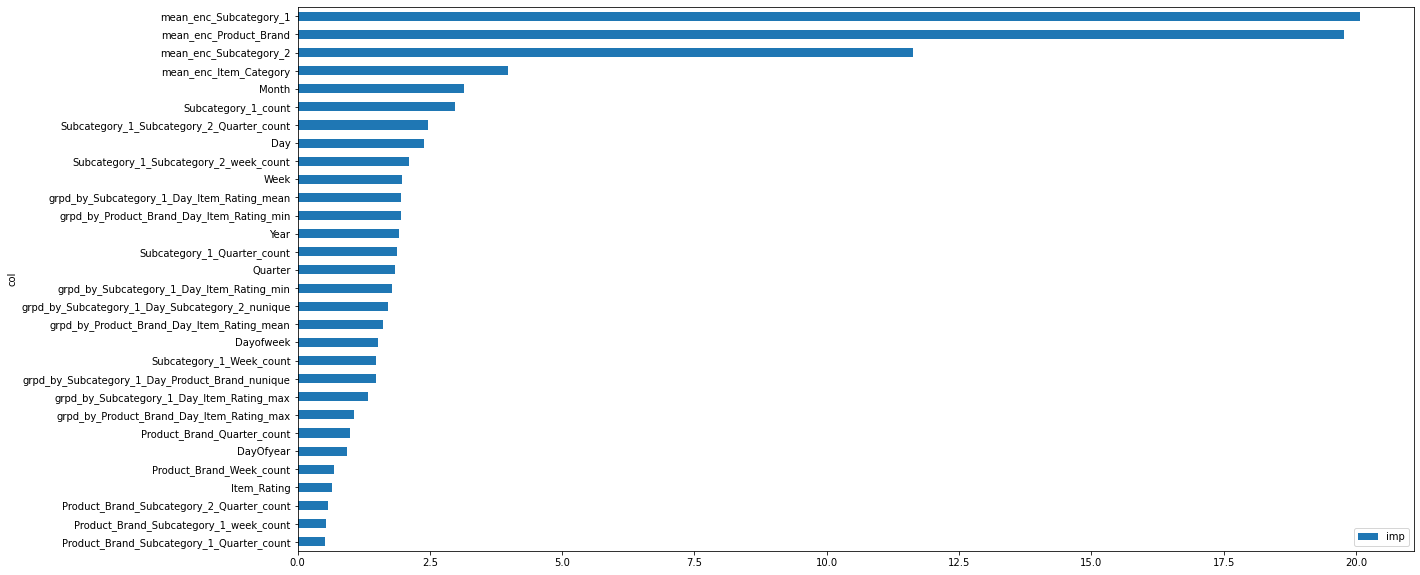

In [107]:
fea_imp = pd.DataFrame({'imp': cat.feature_importances_, 'col': cols})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png') 

#### Random seed output - Catboost and LightGBM

In [108]:
all_preds = pd.DataFrame()

for seed_ in np.arange(1000, 1021):
    print(seed_)
    categorical_features_indices = [1,2,3,4,5,6,7,14,15]
    cat=CatBoostRegressor(iterations=1500, loss_function= 'RMSE', random_seed=seed_,verbose=0)

    cat.fit(X, y,cat_features=categorical_features_indices)

    all_preds["cb_seed_{}".format(seed_)] = cat.predict(test_X)

1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020


In [110]:
for seed_ in np.arange(1000, 1021):
    print(seed_)
    lg = LGBMRegressor(n_estimators=1000, num_leaves=127, max_depth=-1,min_child_samples=4, learning_rate=0.01,
                        colsample_bytree=0.4, reg_alpha=0.5, reg_lambda=2, random_state=seed_)
    lg.fit(X, y, eval_metric='rmse')    
    all_preds["lgb_seed_{}".format(seed_)] = lg.predict(test_X)

1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020


In [0]:
cb_cols = [col for col in all_preds if col.startswith("cb")]
lgb_cols = [col for col in all_preds if col.startswith("lgb")]

In [112]:
all_preds.shape

(1051, 42)

In [113]:
all_preds.head()

,cb_seed_1000,cb_seed_1001,cb_seed_1002,cb_seed_1003,cb_seed_1004,cb_seed_1005,cb_seed_1006,cb_seed_1007,cb_seed_1008,cb_seed_1009,cb_seed_1010,cb_seed_1011,cb_seed_1012,cb_seed_1013,cb_seed_1014,cb_seed_1015,cb_seed_1016,cb_seed_1017,cb_seed_1018,cb_seed_1019,cb_seed_1020,lgb_seed_1000,lgb_seed_1001,lgb_seed_1002,lgb_seed_1003,lgb_seed_1004,lgb_seed_1005,lgb_seed_1006,lgb_seed_1007,lgb_seed_1008,lgb_seed_1009,lgb_seed_1010,lgb_seed_1011,lgb_seed_1012,lgb_seed_1013,lgb_seed_1014,lgb_seed_1015,lgb_seed_1016,lgb_seed_1017,lgb_seed_1018,lgb_seed_1019,lgb_seed_1020
0,7.923398,7.804975,7.776262,7.793850,7.868002,7.930779,7.854197,7.869392,7.880137,7.924558,7.883921,7.893913,7.847792,7.890410,7.776644,7.856291,7.832790,7.809843,7.776957,7.888364,7.775684,8.048781,8.102198,8.107890,8.006043,8.088853,8.040020,8.148274,8.074204,8.109429,8.038096,8.092351,8.099348,8.049654,8.078033,8.106874,8.104726,8.099397,8.072956,8.147791,8.075294,8.157379
1,6.413874,6.271045,6.250691,6.303037,6.347321,6.304722,6.407483,6.280689,6.381426,6.462622,6.216751,6.261646,6.473931,6.384078,6.467195,6.350879,6.341058,6.382764,6.378212,6.207249,6.434822,6.483935,6.482705,6.534012,6.514239,6.479238,6.506969,6.488486,6.433578,6.577032,6.431351,6.457886,6.418889,6.398016,6.485874,6.449382,6.521429,6.444722,6.473108,6.538990,6.391101,6.447893
2,6.669806,6.623505,6.617817,6.649263,6.595605,6.656623,6.608124,6.681961,6.634533,6.639547,6.660166,6.632015,6.643027,6.682311,6.633925,6.669814,6.670303,6.660123,6.632277,6.638256,6.637758,6.737545,6.740971,6.729056,6.736639,6.729502,6.719188,6.736682,6.737134,6.729804,6.725376,6.734720,6.739986,6.740060,6.745591,6.733244,6.748460,6.732359,6.738764,6.745325,6.724904,6.733319
3,5.833677,5.828960,5.775227,5.790640,5.815496,5.839347,5.758450,5.807509,5.730160,5.766374,5.782477,5.751688,5.810069,5.811150,5.786377,5.851459,5.847736,5.787174,5.853667,5.811790,5.793085,5.839024,5.837616,5.841773,5.838036,5.801622,5.827935,5.824049,5.805663,5.809035,5.820054,5.797780,5.807028,5.837018,5.812127,5.816243,5.806972,5.834252,5.818826,5.794750,5.792704,5.831459
4,6.661785,6.588918,6.579714,6.635069,6.609747,6.657459,6.596554,6.677652,6.638060,6.622221,6.645422,6.616841,6.637278,6.642622,6.623692,6.667871,6.643436,6.654560,6.639753,6.629632,6.638744,6.722286,6.697898,6.699469,6.714316,6.704683,6.696347,6.714911,6.703440,6.707649,6.695507,6.703340,6.710671,6.713142,6.718800,6.691051,6.723507,6.690553,6.717330,6.712953,6.701141,6.720337


In [0]:
test_preds = hmean((all_preds[cb_cols].mean(1), all_preds[lgb_cols].mean(1).values))

# # Fill the target variable with the predictions
sub_df['Selling_Price']= pd.DataFrame(np.expm1(test_preds))

# # Converting the submission file to excel format
sub_df.to_excel('cb_lg_hmean.xlsx', index=False)